# Programming Assignment: Анализ изображений

Задача заключается в том, чтобы применить предобученную на imagenet нейронную сеть на практической задаче классификации автомобилей. 

Учиться применять нейронные сети для анализа изображений мы будем на библиотеке TensorFlow. Это известный опенсорсный проект, разработанный инженерами Google Brain Team. Подробнее почитать о TensorFlow можно на официальном сайте, на [гитхабе](https://github.com/tensorflow/tensorflow) или [на хабре](https://habrahabr.ru/post/270543/).

### Установка окружения

В первую очередь нам будет необходимо установить **TensorFlow**.
* [Инструкции по установке на сайте](https://www.tensorflow.org/versions/r0.10/get_started/os_setup.html#download-and-setup).
* Если есть опыт работы с Docker, то можно воспользоваться готовым [докер-контейнером с тензорфлоу](https://www.tensorflow.org/versions/r0.10/get_started/os_setup.html#docker-installation).

**Важно!** Если вы пользователь Windows, то уставить tensorflow напрямую, к сожалению, не получится:

* для пользователей Windows 10 (и выше) нужно использовать **Docker** ([ссылка на дистрибутив](https://www.docker.com/products/docker#/windows));
* если у вас Windows старше версии 10, то и вариант с докером не подойдет — он не установится. В таком случае советуем установить линукс на локальную машину как еще одну операционную систему (поможет избежать страданий в будущем при работе с некоторыми библиотеками для ML).

Если же поставить Tensorflow на вашу машину никак не получается, мы предлагаем воспользоваться одним из облачных сервисов, в который необходимо установить линукс-образ. Самые популярные облачные сервисы [AWS](https://aws.amazon.com) и [DigitalOcean](http://digitalocean.com) предоставляют бесплатные инстансы (имейте в виду, что для того, чтобы ими воспользоваться, нужно будет привязать кредитную карту).

Чтобы освоить компьютерное зрение (или другие интересные задачи из области ML и AI), так или иначе придётся научиться работать с библиотеками нейронных сетей, линуксом и виртуальными серверами. Например, для более масштабных практических задач, крайне необходимы сервера с GPU, а с ними уже локально работать не получиться.

Тем не менее, мы понимаем, что в силу временных ограничений курса кто-то может успеть установить TensorFlow. Поэтому мы сделали пункты 1 и 2 необязательными. На оценку они не повлияют — можете сразу переходить к третьему пункту.

Помимо tensorflow, потребуется библиотека **`scipy`**. Если вы уже работали с Anaconda и/или выполняли задания в нашей специализации, то она должна присутствовать.

## Данные

Скачать данные нужно тут: https://yadi.sk/d/6m_KbM4HvmLfs 

Данные это часть выборки _Cars Dataset_ ([link](http://ai.stanford.edu/~jkrause/cars/car_dataset.html)). Исходный датасет содержит 16,185 изображений автомобилей, принадлежащих к 196 классам. Данные разделены на 8,144 тренировочных и 8,041 тестовых изображений, при этом каждый класс разделён приблизительно поровну между тестом и трейном. Все классы уровня параметров _Марка_, _Год_, _Модель_ и др. (например, _2012 Tesla Model S or 2012 BMW M3 coupe_).

В нашем же случае в `train` 204 изображения, и в `test` — 202 изображения.

## Что делать

Помимо данных, потребуется скачать:

* [код](https://github.com/ton4eg/coursera_pa), 
* веса модели [по ссылке](https://yadi.sk/d/9-3kXyxRvnBwh)

Положите данные, код и модель в одну папку. У вас должна получиться такая структура:

```
/assignment-computer-vision/
|
|-- test              # папки  
|    `---- ...        # с
|-- train             # картинками
|    `---- ...
|
|-- class_names.txt   # имена классов, номер строки соответствует id класса
|-- results.txt       # соответствие имя картинки — id класса
|-- vgg16_weights.npz # веса модели в формате tensorflow
|
|-- vgg16.py            # основной скрипт
|-- imagenet_classes.py 
|
`-- beach.jpg         # картиночка с пляжем
```

## Запуск из Docker gcr.io/tensorflow/tensorflow
* докер запускает Jupyter Notebook с рабочей папкой /notebooks
* в докере не хватает библиотек sklearn и Pillow

Рекомендуется запускать докер командой

docker run -it -p 127.0.0.1:8888:8888 -v $PWD:/notebooks gcr.io/tensorflow/tensorflow

при запуске из папки, где лежит данный ноутбук и все нужные файлы, они сразу окажутся в рабочей папке Jupyter 
Notebook.

Следующие две ячейки содержат команды, доустанавливающие нужные библиотеки.

In [ ]:
!pip install sklearn

In [ ]:
!pip install -U pillow

Импортируем всё, что нам нужно для работы.

In [11]:
# inspired by
# http://www.cs.toronto.edu/~frossard/post/vgg16/                               
# Model from https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md     #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #

import glob
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
from imageio import imread
from skimage.transform import resize
from imagenet_classes import class_names
import sys
from sklearn.svm import SVC
from matplotlib import pyplot as plt

В этом классе содержится описание модели VGG - структура, инициализация, загрузка весов. Следует помнить - пока не запущена сессия Tensorflow, никакой реальной работы не производится.

In [2]:
class vgg16:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print(i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))



In [3]:
# Функция сохранения в файл ответа, состоящего из одного числа
def save_answerNum(fname,number):
    with open(fname,"w") as fout:
        fout.write(str(number))

In [4]:
# Функция сохранения в файл ответа, представленного массивом
def save_answerArray(fname,array):
    with open(fname,"w") as fout:
        fout.write(" ".join([str(el) for el in array]))

In [5]:
# Загрузка словаря из текстового файла. Словарь у нас используется для сохранения меток классов в выборке data.
def load_txt(fname):
    line_dict = {}
    for line in open(fname):
        fname, class_id = line.strip().split()
        line_dict[fname] = class_id

    return line_dict

In [6]:
# Функция обработки отдельного изображения, печатает метки TOP-5 классов и уверенность модели в каждом из них.
def process_image(fname):
    img1 = imread(fname, pilmode='RGB')
    img1 = resize(img1, (224, 224))
    
    prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
    preds = (np.argsort(prob)[::-1])[0:5]
    for p in preds:
        print(class_names[p], prob[p])

In [8]:
# Инициируем TF сессию, и инициализируем модель. На этом шаге модель загружает веса. Веса - это 500Мб в сжатом виде
# и ~2.5Гб в памяти, процесс их загрузки послойно выводится ниже этой ячейки, и если вы увидите этот вывод ещё раз - 
# у вас неистово кончается память. Остановитесь. Также, не запускайте эту ячейку на выполнение больше одного раза
# за запуск ядра Jupyter.
sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = vgg16(imgs, 'vgg16_weights.npz', sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


Все ячейки выше не нуждаются в модификации для выполнения задания, и необходимы к исполнению только один раз, в порядке следования. Повторный запуск ячейки с инициализацией модели будет сжирать память. Вы предупреждены.

## Задание 1\. 

Для начала нужно запустить готовую модель `vgg16`, предобученную на `imagenet`. Модель обучена с помощью `caffe` и сконвертирована в формат `tensorflow` - `vgg16_weights.npz`. Скрипт, иллюстрирующий применение этой модели к изображению, возвращает топ-5 классов из `imagenet` и уверенность в этих классах.

**Задание:** Загрузите уверенность для первого класса для изображения `train/00002.jpg` с точностью до 1 знака после запятой в файл с ответом.

matchstick 0.075511634
nematode, nematode worm, roundworm 0.049533404
lighter, light, igniter, ignitor 0.03023764
digital clock 0.029393047
spotlight, spot 0.023299327


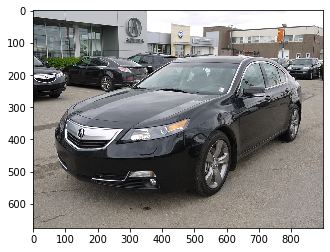

In [44]:
# Ваш код здесь
img1 = imread('train/00002.jpg', pilmode='RGB')
plt.imshow(img1)
process_image('train/00002.jpg')

In [45]:
save_answerNum('ans1.txt', 0.4)

## Задание 2\. 

Научитесь извлекать `fc2` слой. Возьмите за основу код `process_image`, и модифицируйте, чтобы вместо последнего слоя извлекались выходы `fc2`.

**Задание:** Посчитайте `fc2` для картинки `train/00002.jpg`.  Запишите первые 20 компонент.

In [22]:
img1 = imread('data/train/00002.jpg', pilmode='RGB')
img1 = resize(img1, (224, 224))

fc2 = sess.run(vgg.fc2, feed_dict={vgg.imgs: [img1]})[0]
fc2[:20]

array([0.0000000e+00, 3.8728166e-01, 2.2650313e-01, 9.1045487e-01,
       1.1771917e-04, 0.0000000e+00, 1.1112179e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.4018711e-01, 0.0000000e+00,
       2.3020558e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [23]:
save_answerArray('ans2.txt', fc2[:20])

## Задание 3\. 

Теперь необходимо дообучить классификатор на нашей базе. В качестве бейзлайна предлагается воспользоваться классификатором `svm` из пакета `scipy`.

- Модифицировать функцию `get_features` и добавить возможность вычислять `fc2`. (Аналогично второму заданию).
- Применить `get_feautures`, чтобы получить `X_test` и `Y_test`.
- Воспользоваться классификатором `SVC` с `random_state=0`.

> **Важно!** Если вам не удалось поставить `tensorflow`, то необходимо вместо использования функции `get_features`, загрузить предпосчитанные `X`, `Y`, `X_test`, `Y_test` из архива: https://yadi.sk/d/RzMOK8Fjvs6Ln и воспользоваться функцией `np.load` для их загрузки, а после этого два последних пункта.

**Задание:** Сколько правильных ответов получается на валидационной выборке из папки `test`? Запишите в файл.

In [24]:
# Функция, возвращающая признаковое описание для каждого файла jpg в заданной папке
def get_features(folder, ydict):

    paths = glob.glob(folder)
    X = np.zeros((len(paths), 4096))
    Y = np.zeros(len(paths))

    for i,img_name in enumerate(paths):
        print(img_name)
        base = os.path.basename(img_name)
        Y[i] = ydict[base]

        img1 = imread('train/00002.jpg', pilmode='RGB')
        img1 = resize(img1, (224, 224))
        fc2 = sess.run(vgg.fc2, feed_dict={vgg.imgs: [img1]})[0]
        
        X[i, :] = fc2
    
    return X, Y

In [41]:
# Функция обработки папки. Ожидается, что в этой папке лежит файл results.txt с метками классов, и 
# имеются подразделы train и test с jpg файлами.
def process_folder(folder):
    ydict = load_txt(os.path.join(folder,'results.txt'))
    
    X, Y = get_features(os.path.join(folder, 'train/*jpg'), ydict)
    # Ваш код здесь. 
    X_test, Y_test = get_features(os.path.join(folder, 'train/*jpg'), ydict)

    # Ваш код здесь. 
    clf = SVC(random_state=17)
    clf.fit(X_test, Y_test)
    
    Y_test_pred = clf.predict(X_test)
    print(sum(Y_test == Y_test_pred)) # Число правильно предсказанных классов
    

In [42]:
process_folder('.') # Вызови меня! 

./train/02359.jpg
./train/03715.jpg
./train/01972.jpg
./train/03575.jpg
./train/01918.jpg
./train/00920.jpg
./train/03054.jpg
./train/03761.jpg
./train/02058.jpg
./train/00081.jpg
./train/01361.jpg
./train/03152.jpg
./train/03064.jpg
./train/02274.jpg
./train/00244.jpg
./train/00425.jpg
./train/02240.jpg
./train/01034.jpg
./train/02663.jpg
./train/02670.jpg
./train/00887.jpg
./train/01012.jpg
./train/03813.jpg
./train/03659.jpg
./train/02145.jpg
./train/02124.jpg
./train/00522.jpg
./train/01678.jpg
./train/03772.jpg
./train/00002.jpg
./train/00912.jpg
./train/03537.jpg
./train/01214.jpg
./train/03795.jpg
./train/00691.jpg
./train/02377.jpg
./train/02364.jpg
./train/02311.jpg
./train/03454.jpg
./train/02326.jpg
./train/02457.jpg
./train/03828.jpg
./train/01680.jpg
./train/02832.jpg
./train/03790.jpg
./train/03308.jpg
./train/01832.jpg
./train/01864.jpg
./train/03690.jpg
./train/01322.jpg
./train/03854.jpg
./train/00198.jpg
./train/00392.jpg
./train/03127.jpg
./train/00163.jpg
./train/00

In [46]:
save_answerNum("ans3.txt", 89 )